In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# CUDA 디버깅 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#### MNIST 외의 다른 이미지 데이터셋으로 신경망 학습해보기 - CIFAR100

1. 기본 딥러닝 모델 확장
- 신경망(SimpleNN)을 확장하여 더 깊고 복잡한 모델을 만들어보기

In [3]:
# 신경망 모델 정의
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 128)  # 입력층: 28x28 이미지를 1차원 배열로 변환, 128개의 뉴런
        self.fc2 = nn.Linear(128, 64)   # 첫 번째 히든 레이어: 128차원, 두 번째 히든 레이어: 64차원
        self.fc3 = nn.Linear(64, 32)   # 첫 번째 히든 레이어: 128차원, 두 번째 히든 레이어: 64차원
        self.fc4 = nn.Linear(32, 10)  # 출력층: 10개의 뉴런 (0~9 클래스)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # 이미지를 1차원 배열로 변환
        x = F.relu(self.fc1(x))  # 은닉층: ReLU 활성화 함수 적용
        x = F.relu(self.fc2(x))  # 은닉층: ReLU 활성화 함수 적용
        x = F.relu(self.fc3(x))  # 은닉층: ReLU 활성화 함수 적용
        x = self.fc4(x)  # 출력층
        return F.log_softmax(x, dim=1)  # 소프트맥스 함수로 클래스 확률 반환

In [4]:
# 데이터셋과 데이터 로더 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 데이터를 0.5의 평균과 0.5의 표준편차로 정규화

In [5]:
# 훈련 데이터셋과 테스트 데이터셋 다운로드 및 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [7]:
# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)

In [8]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 교차 엔트로피 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD 옵티마이저

In [9]:
print(model)

SimpleNN(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)


In [15]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 데이터를 장치로 이동
        optimizer.zero_grad()  # 이전 기울기 초기화
        output = model(data)  # 모델 예측
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파를 통해 기울기 계산
        optimizer.step()  # 가중치 업데이트

        train_loss += loss.item()  # 배치 손실 합산

        # 학습 정확도 계산
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % 100 == 0:  # 100번째 배치마다 로그 출력
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)  # 평균 손실 계산
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

In [16]:
# 모델 평가 함수 정의
def test(model, device, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0
    correct = 0
    with torch.no_grad():  # 평가 시에는 기울기를 계산하지 않음
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # 손실 합산
            pred = output.argmax(dim=1, keepdim=True)  # 가장 높은 확률을 가진 클래스 예측
            correct += pred.eq(target.view_as(pred)).sum().item()  # 맞춘 개수 합산

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({test_accuracy:.0f}%)\n')
    return test_loss, test_accuracy

In [24]:
epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

In [18]:
print(device)

cuda


In [27]:
# 모델 학습
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.869901
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.058957
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.840430
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.111066
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.176010
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.024684
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.073124
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.021685

Test set: Average loss: 0.0219, Accuracy: 5222/10000 (52%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.173053
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.922772
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.061048
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.109659
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.178893
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.112521
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.793191
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.249540

Test set: Average loss: 0.0222, Accuracy: 5273/10000 (53%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.317234
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.974

In [28]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         393,344
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 32]           2,080
            Linear-4                   [-1, 10]             330
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.54
Estimated Total Size (MB): 1.55
----------------------------------------------------------------


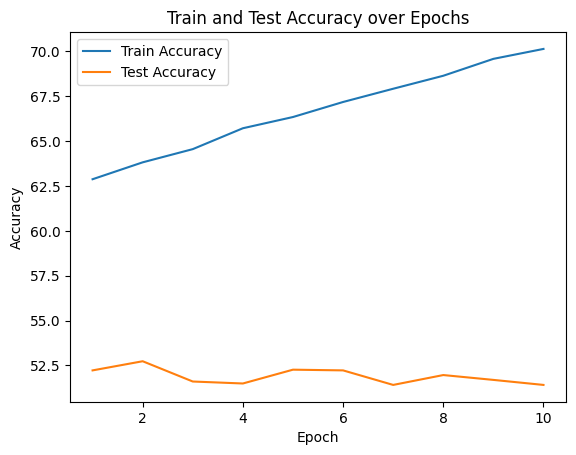

In [30]:
# 정확도 그래프 그리기
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.show()